# Ghouls, Goblins and Ghost (kaggle competition)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score


Here we start with importing data and some basic EDA.

In [2]:
train = pd.read_csv('train.csv', index_col=False)
test = pd.read_csv('test.csv')

In [3]:
print(train.shape)
print(test.shape)

(371, 7)
(529, 6)


In [4]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [5]:
train.tail()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
366,886,0.458132,0.391760,0.660590,0.635689,blue,Goblin
367,889,0.331936,0.564836,0.539216,0.551471,green,Ghost
368,890,0.481640,0.501147,0.496446,0.544003,clear,Ghoul
369,896,0.294943,0.771286,0.583503,0.300618,clear,Ghost
370,897,0.670200,0.768469,0.737274,0.608384,white,Ghoul


In [6]:
train.describe() 

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


In [7]:
#Dropping ID column
train.drop('id',axis=1,inplace=True)
test1 = test.drop('id',axis=1)

In [8]:
train.isnull().sum()

bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
type             0
dtype: int64

Nice. There is no missing values.

In [9]:
train.dtypes

bone_length      float64
rotting_flesh    float64
hair_length      float64
has_soul         float64
color             object
type              object
dtype: object

In [10]:
train['type'].value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

We'll do some visualization here.

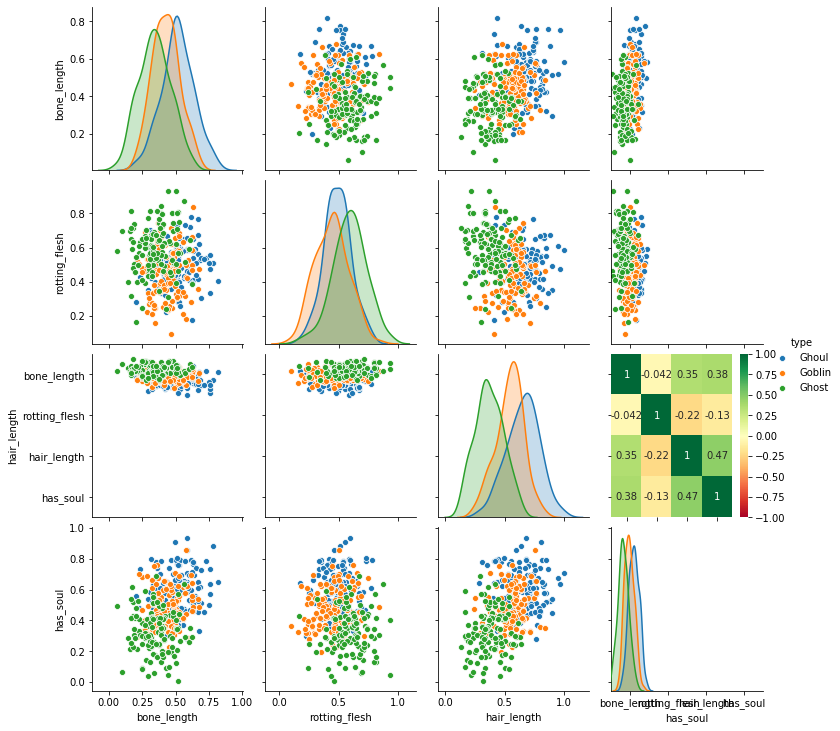

In [11]:
sns.pairplot(train,hue='type') 
sns.heatmap(train.corr(),annot=True,vmin=-1,vmax=1,cmap='RdYlGn')
        

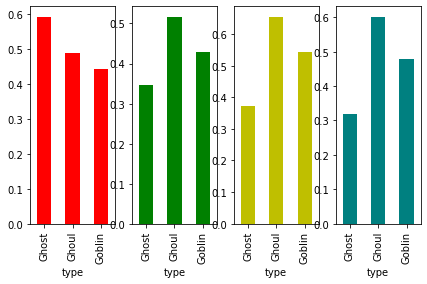

In [12]:
plt.subplot(1,4,1)
train.groupby('type').mean()['rotting_flesh'].plot(kind='bar',figsize=(7,4), color='r')
plt.subplot(1,4,2)
train.groupby('type').mean()['bone_length'].plot(kind='https://www.youtube.com/watch?v=gw2nclcoFNEbar',figsize=(7,4), color='g')
plt.subplot(1,4,3)
train.groupby('type').mean()['hair_length'].plot(kind='bar',figsize=(7,4), color='y')
plt.subplot(1,4,4)
train.groupby('type').mean()['has_soul'].plot(kind='bar',figsize=(7,4), color='teal')

And while most pairs are widely scattered (in relationship to the type), some of them show clusters: hair_length and has_soul, hair_length and bone_length. I decided to create new variables with multiplication of these columns

Actually, after some data preparation, I've found out that this new features give us a better result. These new features increased accuracy from ~ 69-72% to ~71-74%

In [11]:
train['hair_soul'] = train['hair_length'] * train['has_soul']
train['hair_bone'] = train['hair_length'] * train['bone_length']
test1['hair_soul'] = test1['hair_length'] * test1['has_soul']
test1['hair_bone'] = test1['hair_length'] * test1['bone_length']
train['hair_soul_bone'] = train['hair_length'] * train['has_soul'] * train['bone_length']
test1['hair_soul_bone'] = test1['hair_length'] * test1['has_soul'] * test1['bone_length']

train['hair_soul2'] = train['hair_soul']**2
train['hair_bone2'] = train['hair_bone']**2
test1['hair_soul2'] = test1['hair_soul']**2
test1['hair_bone2'] = test1['hair_bone']**2
train['hair_soul_bone2'] = train['hair_soul_bone']**2
test1['hair_soul_bone2'] = test1['hair_soul_bone']**2 

Let's encode 'color' label.


In [12]:
from sklearn.preprocessing import LabelEncoder

label=LabelEncoder()
        
train['color']=label.fit_transform(train['color'])
# train['type']=label.fit_transform(train['type'])

test1['color']=label.fit_transform(test1['color'])

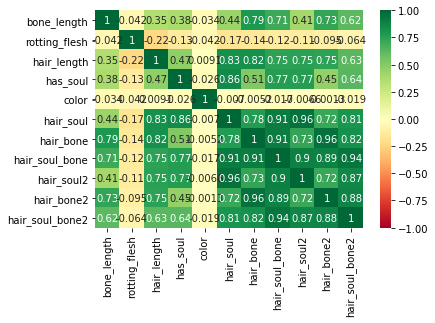

In [18]:
sns.heatmap(train.corr(),annot=True,vmin=-1,vmax=1,cmap='RdYlGn')

we might notice from pairplot and heat matrix that "color" may not be helpful for us

so, we'll drop this feature


In [13]:
train.drop('color',axis=1,inplace=True)
test1.drop('color',axis=1,inplace=True)

I'll check once again with a new features

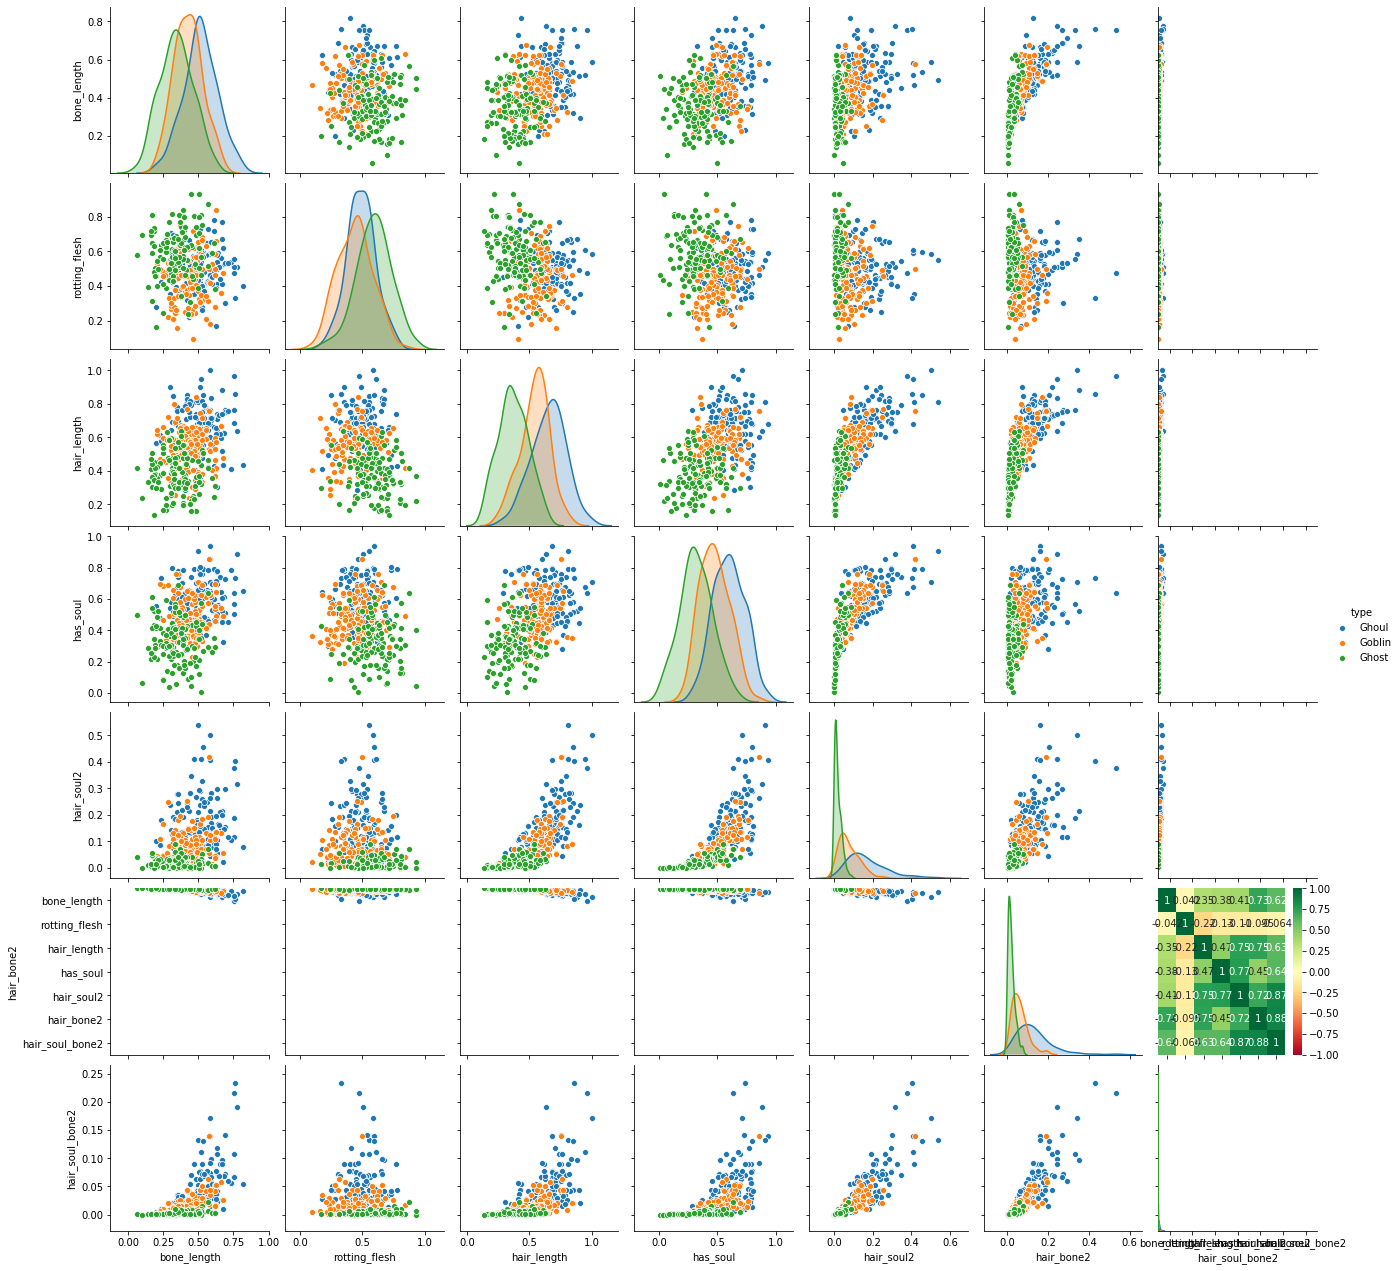

In [22]:
sns.pairplot(train,hue='type') 
sns.heatmap(train.corr(),annot=True,vmin=-1,vmax=1,cmap='RdYlGn')

The main issue here is a bad differentiation between Ghouls and Goblins classes.

In [14]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingClassifier

In [15]:
X_train = train.drop('type', axis=1)
le = LabelEncoder()
Y_train = le.fit_transform(train.type.values)
X_test = test1

In [25]:
X_train.head()

,bone_length,rotting_flesh,hair_length,has_soul,hair_soul2,hair_bone2,hair_soul_bone2
0,0.354512,0.350839,0.465761,0.781142,0.132369,0.027264,0.016636
1,0.575560,0.425868,0.531401,0.439899,0.054645,0.093546,0.018102
2,0.467875,0.354330,0.811616,0.791225,0.412383,0.144199,0.090274
3,0.776652,0.508723,0.636766,0.884464,0.317190,0.244575,0.191325
4,0.566117,0.875862,0.418594,0.636438,0.070974,0.056156,0.022746


Now we'll look at feature importances

In [16]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, Y_train)
indices = np.argsort(clf.feature_importances_)[::-1]

# Print the feature ranking
print('Feature ranking:')

for f in range(X_train.shape[1]):
    print('%d. feature %d %s (%f)' % (f + 1, indices[f], X_train.columns[indices[f]],
                                      clf.feature_importances_[indices[f]]))

Feature ranking:
1. feature 9 hair_soul_bone2 (0.163421)
2. feature 6 hair_soul_bone (0.150632)
3. feature 4 hair_soul (0.113467)
4. feature 1 rotting_flesh (0.110454)
5. feature 7 hair_soul2 (0.106379)
6. feature 8 hair_bone2 (0.086023)
7. feature 2 hair_length (0.078028)
8. feature 5 hair_bone (0.075095)
9. feature 3 has_soul (0.062761)
10. feature 0 bone_length (0.053739)


In [17]:
#Splitting data for validation
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, Y_train, test_size=0.20, random_state=36)

In [34]:
forest = RandomForestClassifier(max_depth = 100,                                
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 60)

parameter_grid = {'n_estimators' : [10, 20, 100, 150],
                  'criterion' : ['gini', 'entropy'],
                  'max_features' : ['auto', 'sqrt', 'log2', None]
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, scoring='accuracy', cv=StratifiedKFold(5))
grid_search.fit(Xtrain, ytrain)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7601129943502826
Best parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 10}


In [35]:
forest = RandomForestClassifier(n_estimators = 10,
                                criterion = 'entropy',
                                max_features = None)
parameter_grid = {
                  'max_depth' : [None, 5, 20, 100],
                  'min_samples_split' : [2, 5, 7],
                  'min_weight_fraction_leaf' : [0.0, 0.1],
                  'max_leaf_nodes' : [40, 60, 80],
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, scoring='accuracy', cv=StratifiedKFold(5))
grid_search.fit(Xtrain, ytrain)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7666666666666668
Best parameters: {'max_depth': 100, 'max_leaf_nodes': 60, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.1}


In [42]:
#Optimal parameters
clf = RandomForestClassifier(n_estimators=10, n_jobs=-1, criterion = 'entropy', max_features = None,
                             min_samples_split=7, min_weight_fraction_leaf=0.1,
                             max_leaf_nodes=60, max_depth=60)
#Calibration improves probability predictions
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
calibrated_clf.fit(Xtrain, ytrain)
y_val = calibrated_clf.predict_proba(Xtest)

print("Validation accuracy: ", sum(pd.DataFrame(y_val, columns=le.classes_).idxmax(axis=1).values
                                   == le.inverse_transform(ytest))/len(ytest))

Validation accuracy:  0.72


I used the best parameters and validation accuracy is ~68-72%. Not bad. But let's try something else.



In [20]:
svc = svm.SVC(kernel='linear')
svc.fit(Xtrain, ytrain)
y_val_s = svc.predict(Xtest)
print("Validation accuracy: ", sum(le.inverse_transform(y_val_s)
                                   == le.inverse_transform(ytest))/len(ytest))

Validation accuracy:  0.7466666666666667


RandomForest requires a lot of data for a good perfomance, looks like it has a little amount of data 

In [24]:
import warnings
warnings.filterwarnings("ignore")

#The last model is logistic regression
logreg = LogisticRegression()

parameter_grid = {'solver' : ['newton-cg', 'lbfgs'],
                  'multi_class' : ['ovr', 'multinomial'],
                  'C' : [0.005, 0.01, 1, 10, 100, 1000],
                  'tol': [0.0001, 0.001, 0.005]
                 }

grid_search = GridSearchCV(logreg, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(Xtrain, ytrain)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7598870056497176
Best parameters: {'C': 100, 'multi_class': 'ovr', 'solver': 'newton-cg', 'tol': 0.0001}


In [47]:
log_reg = LogisticRegression(C = 100, tol = 0.0001, solver='newton-cg', multi_class='ovr')
log_reg.fit(Xtrain, ytrain)
y_val_l = log_reg.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_l, columns=le.classes_).idxmax(axis=1).values
                                   == le.inverse_transform(ytest))/len(ytest))

Validation accuracy:  0.72


## Here we'll try voting


In [50]:
clf = RandomForestClassifier(n_estimators=10, n_jobs=-1, criterion = 'entropy', max_features = None,
                             min_samples_split=7, min_weight_fraction_leaf=0.1,
                             max_leaf_nodes=60, max_depth=60)

calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)

log_reg = LogisticRegression(C = 1, tol = 0.0001, solver='newton-cg', multi_class='multinomial')

gnb = GaussianNB()

In [51]:
calibrated_clf1 = CalibratedClassifierCV(RandomForestClassifier())

log_reg1 = LogisticRegression()

gnb1 = GaussianNB()

In [52]:
Vclf1 = VotingClassifier(estimators=[('LR', log_reg1), ('CRF', calibrated_clf1),
                                     ('GNB', gnb1)], voting='hard')
Vclf = VotingClassifier(estimators=[('LR', log_reg), ('CRF', calibrated_clf),
                                     ('GNB', gnb)], voting='soft', weights=[1,1,1])

In [53]:
hard_predict = le.inverse_transform(Vclf1.fit(X_train, Y_train).predict(X_test))
soft_predict = le.inverse_transform(Vclf.fit(X_train, Y_train).predict(X_test))

We'll look at the difference between hard and soft prerdictions (objects where they gave us a different classes)

In [56]:
for i in range(len(hard_predict)):
    if hard_predict[i] != soft_predict[i]:
        print(i, hard_predict[i], soft_predict[i])

3 Ghost Goblin
16 Goblin Ghoul
20 Ghoul Goblin
39 Ghoul Goblin
40 Goblin Ghost
49 Goblin Ghost
71 Ghost Goblin
83 Ghoul Goblin
96 Goblin Ghost
97 Goblin Ghost
99 Goblin Ghost
111 Goblin Ghost
129 Ghoul Goblin
146 Ghoul Goblin
152 Ghoul Goblin
192 Goblin Ghost
214 Goblin Ghost
215 Goblin Ghost
222 Goblin Ghost
273 Goblin Ghost
281 Goblin Ghost
295 Ghoul Goblin
300 Goblin Ghoul
316 Goblin Ghost
362 Goblin Ghost
374 Goblin Ghost
377 Goblin Ghost
378 Goblin Ghost
383 Goblin Ghost
384 Goblin Ghost
393 Goblin Ghost
394 Ghost Goblin
400 Goblin Ghost
434 Goblin Ghost
464 Goblin Ghost
465 Ghoul Goblin
468 Ghoul Goblin
471 Ghoul Goblin
491 Ghoul Goblin
496 Ghoul Goblin
516 Ghoul Goblin


Now we'll submit the hard prediction, but it will give almost the same result as a soft predictor

In [59]:
submission = pd.DataFrame({'id':test['id'], 'type':hard_predict})


In [60]:
submission.to_csv('GGG_submission.csv', index=False)

I've tried a lot of different approaches with these classifiers and voters to get the best result and usually scores were from ~72% to ~74%. The highest one is 0.74480.